In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker


In [10]:
# Replace the following with your own credentials and details
db_type = "postgresql"
username = "postgres"
password = "GE38rTIV"
host = "flightdelay.cqtoprenvzmu.us-east-2.rds.amazonaws.com"
port = 5432  # Use 3306 for MySQL databases
database_name = "postgres"

# Create the connection string
connection_string = f"{db_type}://{username}:{password}@{host}:{port}/{database_name}"
# Create the engine
engine = create_engine(connection_string)

table_name = "flights"
query = f"SELECT * FROM {table_name}"
flights_df = pd.read_sql(query, engine)
# Change column names to uppercase
flights_df.columns = flights_df.columns.str.upper()

# Display the modified DataFrame
flights_df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,9,4,DL,19790,DL,N3736C,1282,14747,1474703,SEA,...,1289208,LAX,1745.0,0.0,1700-1759,2012.0,0.0,0.0,0.0,954.0
1,9,4,DL,19790,DL,N322US,1283,11292,1129202,DEN,...,1289208,LAX,627.0,0.0,0600-0659,751.0,0.0,0.0,0.0,862.0
2,9,4,DL,19790,DL,N920DE,1284,15370,1537002,TUL,...,1039707,ATL,556.0,0.0,0600-0659,900.0,0.0,0.0,0.0,674.0
3,9,4,DL,19790,DL,N374DA,1285,13930,1393007,ORD,...,1348702,MSP,603.0,0.0,0600-0659,736.0,0.0,0.0,0.0,334.0
4,9,4,DL,19790,DL,N328DN,1286,10397,1039707,ATL,...,1295304,LGA,1030.0,0.0,1000-1059,1222.0,0.0,0.0,0.0,762.0


In [12]:
# Drop unnecessary columns
data = flights_df.drop(columns=['OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_SEQ_ID','ARR_TIME'])

In [13]:
# check for missing values
data.isnull().sum()

DAY_OF_MONTH            0
DAY_OF_WEEK             0
OP_UNIQUE_CARRIER       0
ORIGIN_AIRPORT_ID       0
ORIGIN                  0
DEST_AIRPORT_ID         0
DEST                    0
DEP_TIME             6664
DEP_DEL15            6699
DEP_TIME_BLK            0
ARR_DEL15            8078
CANCELLED               0
DIVERTED                0
DISTANCE                0
dtype: int64

In [14]:
# Drop rows with missing values
data = data.dropna()


In [15]:
# Convert time columns to numeric values
data['DEP_TIME'] = pd.to_numeric(data['DEP_TIME'], errors='coerce', downcast='integer')
data.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,9,4,DL,14747,SEA,12892,LAX,1745,0.0,1700-1759,0.0,0.0,0.0,954.0
1,9,4,DL,11292,DEN,12892,LAX,627,0.0,0600-0659,0.0,0.0,0.0,862.0
2,9,4,DL,15370,TUL,10397,ATL,556,0.0,0600-0659,0.0,0.0,0.0,674.0
3,9,4,DL,13930,ORD,13487,MSP,603,0.0,0600-0659,0.0,0.0,0.0,334.0
4,9,4,DL,10397,ATL,12953,LGA,1030,0.0,1000-1059,0.0,0.0,0.0,762.0


In [16]:
data = pd.get_dummies(data, columns=['DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK'])

In [17]:
# Define features and target
X = data.drop(columns=['ARR_DEL15'])
y = data['ARR_DEL15']

In [18]:
# Train-test split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Initialize the Optimized Gradient Boosting Classifier with the best hyperparameters
best_params = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
clf = GradientBoostingClassifier(**best_params)

In [21]:
# Train the model
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [22]:
# Make predictions on the testing set
y_pred = clf.predict(X_test)

In [23]:
# Evaluate the model
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Training Accuracy: ", train_accuracy)
print("Testing Accuracy: ", test_accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Training Accuracy:  0.9321588439219547
Testing Accuracy:  0.9313581524187762

Confusion Matrix:
 [[99567  3954]
 [ 4273 12060]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    103521
         1.0       0.75      0.74      0.75     16333

    accuracy                           0.93    119854
   macro avg       0.86      0.85      0.85    119854
weighted avg       0.93      0.93      0.93    119854



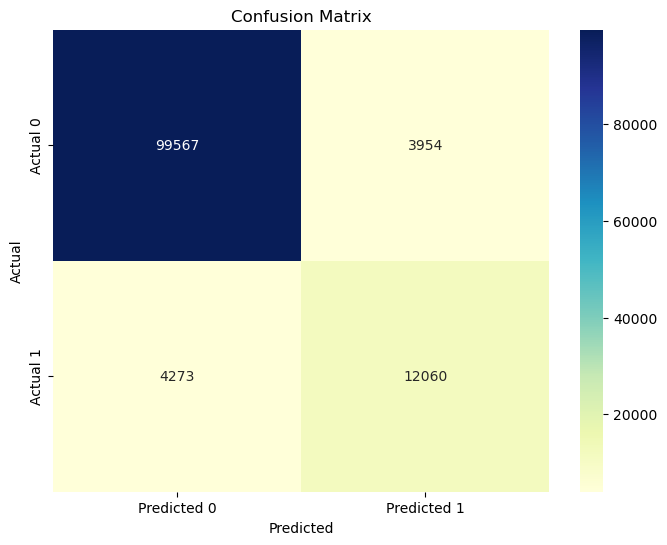

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

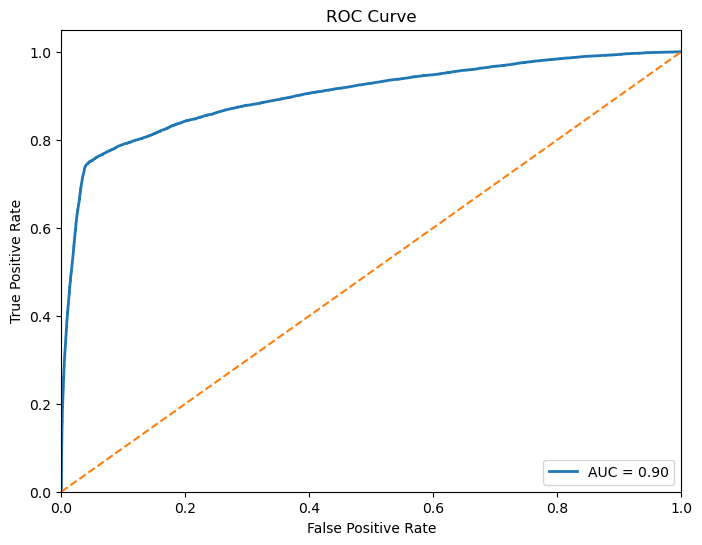

In [29]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

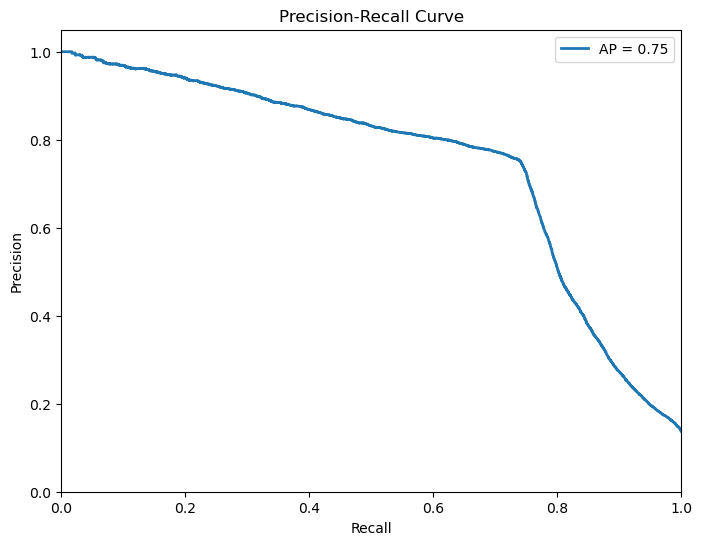

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label='AP = %0.2f' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [31]:
import joblib

# Save the trained model to a file
joblib.dump(clf, 'flight_delay_gradient_boosting_classifier.pkl')


['flight_delay_gradient_boosting_classifier.pkl']